<a href="https://colab.research.google.com/github/Nits11/github-cheat-sheet/blob/master/python_ml_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [243]:
import sklearn
import scipy
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

In [244]:
df = pd.read_csv("model_building_df.csv", dtype = str)

#convert diabetes label to 0 or 1 
#also make a dataframe called 'labels' to use for testing
df['diabetes'] = df['diabetes'].replace('Case', 1)
df['diabetes'] = df['diabetes'].replace('Control', 0)
labels = df['diabetes'].values.astype(int)

#drop diabetes status from dataframe
df = df.drop(['diabetes'], axis = 1)

#make a list with the cat vars in the dataframe (all of them except 'age')
#all of the variables, apart from age, in the model_building_df file are categorical
cat_vars = []
for line in df:
    cat_vars.append(line)
    
cat_vars.remove('age_at_diagnosis')

In [245]:
#this section is for converting age to a categorical variable if desired (optional)
ages = df['age_at_diagnosis'].astype(dtype = 'float').values

def age2cat(age):
    if age < 40:
        return '0'
    elif 40 <= age < 50:
        return '1'
    elif 50 <= age < 60:
        return '2'
    else:
        return '3'

new_ages = []
for age in ages:
    new_age = age2cat(age)
    new_ages.append(new_age)
new_ages = np.array(new_ages)

df['cat_age'] = new_ages
cat_vars.append('cat_age')
cat_df = df[cat_vars]

In [246]:
#encoding of the cat variables
#ohe_cat_vars is the dataset that will be used
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categories = 'auto')
ohe_cat_vars = ohe.fit_transform(cat_df).toarray()

#these steps make a list called 'new_feature_names' that will be used later to show the top features for the model
feature_names = ohe.get_feature_names()

new_feature_names = []
for each in feature_names:
    nm, lvl = each.split("_")
    idx = int(nm[1:])
    cat_name = cat_vars[idx]
    new_feature_name = "{}_{}".format(cat_name, lvl)
    new_feature_names.append(new_feature_name)

In [247]:
#oversampling step because the dataset is imbalanced
#the documentation for imblearn and RandomOverSampler specifically can be found here: https://imbalanced-learn.org/stable/generated/imblearn.over_sampling.RandomOverSampler.html
#this method randomly draws samples from the minority class without replacement until the number of majority/minority samples is approximately the same
#if desired, there are other oversampling methods in the imblearn package 

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

oversample = RandomOverSampler(sampling_strategy = "minority")
model_vars_over, labels_over = oversample.fit_resample(ohe_cat_vars, labels)

#train test split, stratified by class
train_x, test_x, train_y, test_y = train_test_split(model_vars_over, labels_over, test_size = 0.2, random_state = 42, shuffle = True, stratify = labels_over)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [248]:
#cross-validation step
#different scoring parameters can be used (e.g. 'f1', 'precision', 'recall', etc.)
#n_splits = 5 means five-fold CV

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

def five_fold_CV(clf, params, dx, dy):
    cv_model = RandomizedSearchCV(clf, params, scoring = 'f1', n_jobs = -1,
                                  cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42),
                                  verbose = 1,  n_iter = 20, refit = True)

    cv_model.fit(dx, dy)

    return cv_model.best_estimator_, cv_model.best_score_

In [249]:
#defining the plot_auc_roc and get_Younden_idx functions that will be called by the roc_auc_analysis function

import matplotlib.pyplot as plt

def plot_auc_roc(fpr, tpr):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = {:0.4f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def get_Younden_idx(fpr, tpr, threshold):
    idx = np.argmax(np.abs(tpr-fpr))
    return threshold[idx]

In [44]:
#this function plots the roc curve and reads out various metrics (e.g. precision, recall, etc.)
#notice the difference between the variables 'preds' and 'pred_labels'
#preds being probabilities and pred_labels being the predicted classifier (1 or 0)

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score

def roc_auc_analysis(clf, dx, dy):
    preds = clf.predict_proba(dx)
    pred_labels = clf.predict(dx)
    preds = list(map(lambda x: x[-1], preds))
    fpr, tpr, threshold = roc_curve(dy, preds)
    plot_auc_roc(fpr, tpr)
    print("first three predicted probabilities: ", preds[:3])
    print("roc_auc_score: ", roc_auc_score(dy, preds))
   
    #applying the Younden index to increase accuracy (we can exclude this from the final model probably)
    J  = get_Younden_idx(fpr, tpr, threshold)
    print("Youden index: ", J)
    youden_preds = list(map(lambda x: 1 if x >= J else 0, preds))
    print("first three youden predicted results: ", youden_preds[:3])          
    print("accuracy after apply youden index: ", accuracy_score(dy, youden_preds))
   
    #traditional evaluation metrics (feel free to add more)
    print("precision: ", precision_score(dy, pred_labels, average = 'macro'))
    print("recall: ", recall_score(dy, pred_labels, average = 'macro'))


    if isinstance(clf, LogisticRegression):
        cof = clf.coef_.tolist()[0]
        cof_idx = list(zip(cof, range(len(cof))))
        top_5_fea = sorted(cof_idx, key=lambda x: abs(x[0]), reverse=True)[:5]
    elif isinstance(clf, RandomForestClassifier):
       fea_imp = clf.feature_importances_
       top_5_fea = sorted(list(zip(fea_imp, range(len(fea_imp)))), key=lambda x: abs(x[0]), reverse=True)[:5]
    elif isinstance(clf, XGBClassifier):
        fea_imp = clf.feature_importances_
        top_5_fea = sorted(list(zip(fea_imp, range(len(fea_imp)))), key=lambda x: abs(x[0]), reverse=True)[:5]
    else: # SVM
        # for SVM with RGB kernel, this is no straightforward way to get feature improtance
        # https://stats.stackexchange.com/questions/265656/is-there-a-way-to-determine-the-important-features-weight-for-an-svm-that-uses
        pass
        top_5_fea = []
    
    #shows top 5 features (this can be expanded to include more features, you have to tweak the number in the brackets at the end of the top_5_fea variable in the if statements above)
    #you also have to tweak the number in the parantheses of the round() below
    print("top 5 features: ", list(map(lambda x: (new_feature_names[x[1]], round(x[0], 4)), top_5_fea)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


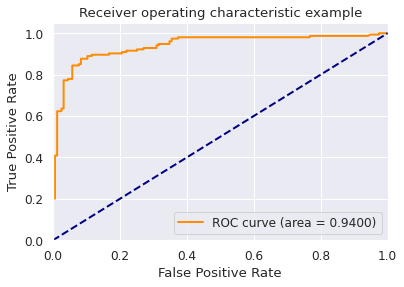

first three predicted probabilities:  [0.22831466096583325, 0.24358716807246944, 0.2322538841394654]
roc_auc_score:  0.9399874319229158
Youden index:  0.4262193200815267
first three youden predicted results:  [0, 0, 0]
accuracy after apply youden index:  0.8964401294498382
precision:  0.8970376639864579
recall:  0.8930456640134059
top 5 features:  [('malaise_and_fatigue_0', -0.1754), ('malaise_and_fatigue_1', 0.1737), ('pure_hypercholesterolemia_0', -0.1705), ('pure_hypercholesterolemia_1', 0.1688), ('lipid_panel_0', -0.1451)]


In [250]:
#logistic regression
#As of yet, I have not found default parameters for the search space.
#Because of this, I'm just using the distributions that Mr. Yang used in the previous lecture for logistic regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver = "saga", max_iter = 100, random_state=13)

#define search space hyperparameter ranges
params_lr = {'max_iter': [10, 50, 100, 200, 500, 750, 1000], 
                    'tol': [0.0001, 0.001, 0.01, 0.1],
                    'C': [0.01, 0.1, 1.0, 5.0, 10.0, 25.0, 50.0, 100.0],
                    'solver': ['lbfgs', 'liblinear', 'newton-cg'], 
                    'class_weight': [None, 'balanced']}

best_lr_model, best_cv_performance = five_fold_CV(lr, params_lr, train_x, train_y)
best_lr_model, best_cv_performance = five_fold_CV(lr, params_lr, test_x, test_y)

roc_auc_analysis(best_lr_model, test_x, test_y)

# XGBoost

In [ ]:
# XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
#               importance_type='gain', interaction_constraints='',
#               learning_rate=0.300000012, max_delta_step=0, max_depth=6,
#               min_child_weight=1, missing=nan, monotone_constraints='()',
#               n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
#               reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
#               tree_method='exact', validate_parameters=1, verbosity=None)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.0s finished


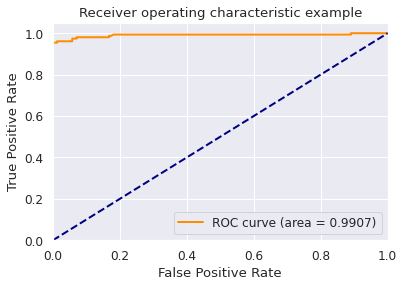

first three predicted probabilities:  [0.0041516167, 0.08773391, 0.012165126]
roc_auc_score:  0.9906786761625471
Youden index:  0.31801784
first three youden predicted results:  [0, 0, 0]
accuracy after apply youden index:  0.9773462783171522
precision:  0.9585798816568047
recall:  0.9545454545454546
top 5 features:  [('pure_hypercholesterolemia_0', 0.3256), ('atrial_fibrillation_0', 0.1271), ('congestive_heart_failure_0', 0.0673), ('cat_age_0', 0.0608), ('malaise_and_fatigue_0', 0.0533)]


In [251]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

#define search space hyperparameter ranges
params_xgb = {'n_estimators': [10, 50, 100], 
                    'max_depth': [3, 6, 10],
                    'learning_rate': [0.1, 0.3, 0.5]}

best_xgb_model, best_cv_performance = five_fold_CV(xgb, params_xgb, train_x, train_y)

roc_auc_analysis(best_xgb_model, test_x, test_y)

In [ ]:
# Calculate F1 score
from sklearn.metrics import f1_score

y_pred = best_xgb_model.predict(test_x)
y_true = test_y
f1_score(y_true, y_pred)

0.9463087248322148

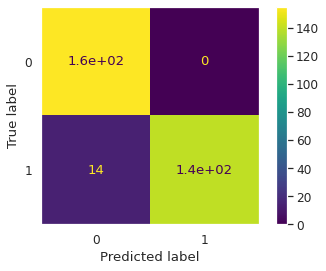

In [252]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# print(confusion_matrix(y_true, y_pred))

plot_confusion_matrix(best_xgb_model, test_x, test_y);
plt.grid(False)

In [254]:
# Extract top 10 impostant features 
f_imp = sorted(zip(best_xgb_model.feature_importances_, new_feature_names))[::-1][:20]

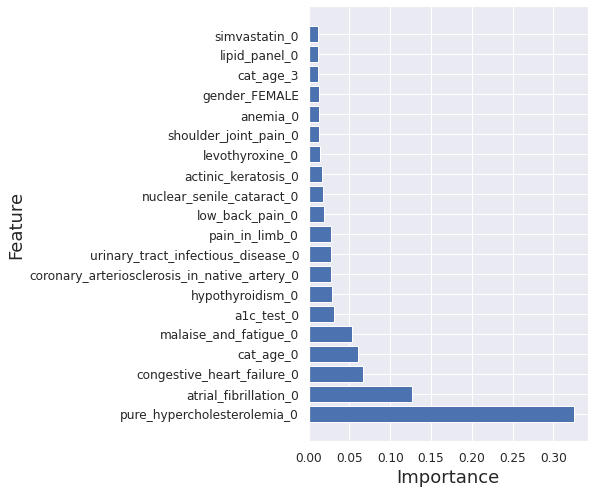

In [255]:
# plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'lines.linewidth': 1, 'lines.markersize': 10})
sns.set(style="darkgrid", font_scale=1.1)

plt.figure(figsize=(5, 8))

plt.barh([i[1] for i in f_imp], [i[0] for i in f_imp])
plt.xlabel('Importance', fontsize=18)
plt.ylabel('Feature', fontsize=18)
plt.show()

##__Random Forest Classifier__

In [61]:
#Import Required Functions
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint


##Additional functions to evaluate and compare model Performances

In [218]:
from sklearn import model_selection

metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html
# scoring metrics from cross validation
scoring_metrics = ['test_' + x for x in metrics]
# needs to be outside function to ensure every model uses the same cv splits for measuring model performance
kfold = model_selection.StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# create function to return cv results for a given model. That way we would not have to loop
# through multiple models anytime we'd like to test a new model
def get_model_metrics(model,dx, dy):

    cv_results = model_selection.cross_validate(
        model, dx, dy, cv=kfold, scoring=metrics)
    df = pd.DataFrame(columns=['Metric', 'Value'])
    for metric in scoring_metrics:
        score_value = round(cv_results[metric].mean(), 2)
        df = df.append({'Metric': metric, 'Value': score_value}, 
                 ignore_index=True)
       # print(metric, round(score_value, 2))
    return(df)
    

# Define a function to compare the model accuracy
def get_model_comparison(base_model,tuned_model,dx,dy):
  base_model_accuracy = get_model_metrics(base_model, dx, dy)
  tuned_model_accuracy = get_model_metrics(tuned_model, dx, dy)
  a= tuned_model_accuracy.iloc[:,0]
  b= round((tuned_model_accuracy.iloc[:,1]- base_model_accuracy.iloc[:,1])/base_model_accuracy.iloc[:,1] *100,3)
  res = "\n".join("{} {}".format(x, y) for x, y in zip(a, b))
  print("\n","Inprovement in metrics:")
  print(res)  

In [62]:
#Check defalut parameters
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


We tried to fine tune few parameters:
* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

###First use the random grid search to narrow down the paramteres

In [172]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#scoring criteria
score = ['gini', 'entropy']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion' : score}
pprint(random_grid)

{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [173]:
# Use previously defined Random grid seach croos-fold validation
# def five_fold_CV(clf, params, dx, dy):
#     cv_model = RandomizedSearchCV(clf, params, scoring = 'f1', n_jobs = -1,
#                                   cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42),
#                                   verbose = 1,  n_iter = 20)

#     cv_model.fit(dx, dy)

#     return cv_model.best_estimator_, cv_model.best_score_

best_rf_model, best_rf_cv_performance = five_fold_CV(rf, random_grid, train_x, train_y)



Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=90, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


0.9552622600205295

In [216]:
print ( "Best performance score of best model in random search", round(best_rf_cv_performance,3))
print ( "Best performance metrics of best model on training data")
print(get_model_metrics(best_rf_model, train_x, train_y))

print ( "Best performance metrics of best model on test data")
get_model_metrics(best_rf_model, test_x, test_y)

Best performance score of best model in random search 0.955
Best performance metrics of best model on training data
           Metric  Value
0   test_accuracy   0.96
1  test_precision   0.98
2     test_recall   0.93
3         test_f1   0.96
4    test_roc_auc   0.99
Best performance metrics of best model on test data


,Metric,Value
0,test_accuracy,0.89
1,test_precision,0.92
2,test_recall,0.86
3,test_f1,0.89
4,test_roc_auc,0.95


###Compare performance with base model to fine tuned model

In [210]:
#Base model accuracy 
baseRF_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
baseRF_model.fit(train_x, train_y)



 Inprovement in metrics:
test_accuracy 3.488
test_precision 1.099
test_recall 6.173
test_f1 4.706
test_roc_auc 2.151


In [219]:
#Comparison on Training data
get_model_comparison(baseRF_model,best_rf_model, train_x, train_y)


 Inprovement in metrics:
test_accuracy 2.128
test_precision 0.0
test_recall 3.333
test_f1 2.128
test_roc_auc 1.02


In [220]:
#Comparison on Test  data
get_model_comparison(baseRF_model,best_rf_model, test_x, test_y)


 Inprovement in metrics:
test_accuracy 3.488
test_precision 1.099
test_recall 6.173
test_f1 4.706
test_roc_auc 2.151


### Further try to improve with more exhuastive grid search

In [199]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [2, 3, 4, 5],
    'min_samples_split': [2, 5, 10 ],
    'n_estimators': [ 300,600, 1000],
    'criterion': ['entropy']
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                           scoring = 'f1',
                           cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42),
                           n_jobs = -1, verbose = 2)

In [200]:
#Fit the model , Use prefit, will take a while to run
grid_search.fit(train_x, train_y)
best_grid_rf_model, best_grid_rf_cv_performance = grid_search.best_estimator_, grid_search.best_score_


Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 32.1min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 35.5min finished


In [ ]:
#Compare the model parameters from two fine-tuning approaches
# Best Model parameters from Grid search 
print ( "Best performance score of best model in random search", round(best_grid_rf_cv_performance,3))



### Evaluate Model parameters from all tested models

In [237]:
#Model parameters of Base model 
print(baseRF_model)
# Best Model parameters from Random search 
print(best_rf_model)

# Best Model parameters from Grid search 
print(best_grid_rf_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=90, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=N

##Coparisons of Performance metrix for best model on Train data

In [235]:

print("Comparison of  metrics of best model on Train data","\n")
print("Base Model Metrics:","\n", get_model_metrics(baseRF_model, train_x, train_y))
print("Best Grid search Model Metrics:","\n", get_model_metrics(best_grid_rf_model, train_x, train_y))
print("Best Random search Model Metrics:","\n",get_model_metrics(best_rf_model, train_x, train_y))




Comparison of  metrics of best model on Train data 

Base Model Metrics: 
            Metric  Value
0   test_accuracy   0.94
1  test_precision   0.98
2     test_recall   0.90
3         test_f1   0.94
4    test_roc_auc   0.98
Best Grid search Model Metrics: 
            Metric  Value
0   test_accuracy   0.94
1  test_precision   0.97
2     test_recall   0.92
3         test_f1   0.94
4    test_roc_auc   0.98
Best Random search Model Metrics: 
            Metric  Value
0   test_accuracy   0.96
1  test_precision   0.98
2     test_recall   0.93
3         test_f1   0.96
4    test_roc_auc   0.99


In [234]:
print("Coparative % improvemet in Random search model from base model:","\n") 
print(get_model_comparison(baseRF_model, best_rf_model, train_x, train_y))
print("\n", "Coparative % improvemet in Grid search model from base model:")
print(get_model_comparison(baseRF_model, best_grid_rf_model, train_x, train_y))
print("\n","Coparative % improvemet in Random search model from Grid search model model:")
print(get_model_comparison(best_grid_rf_model,best_rf_model, train_x, train_y))


Coparative % improvemet in Random search model from base model: 


 Inprovement in metrics:
test_accuracy 2.128
test_precision 0.0
test_recall 3.333
test_f1 2.128
test_roc_auc 1.02
None

 Coparative % improvemet in Grid search model from base model:

 Inprovement in metrics:
test_accuracy 0.0
test_precision -1.02
test_recall 2.222
test_f1 0.0
test_roc_auc 0.0
None

 Coparative % improvemet in Random search model from Grid search model model:

 Inprovement in metrics:
test_accuracy 2.128
test_precision 1.031
test_recall 1.087
test_f1 2.128
test_roc_auc 1.02
None


##Coparisons of Performance metrix for best model on Test data

In [236]:

print("Comparison of  metrics of best model on Test data","\n")
print("Base Model Metrics:","\n", get_model_metrics(baseRF_model, test_x, test_y))
print("Best Grid search Model Metrics:","\n", get_model_metrics(best_grid_rf_model, test_x, test_y))
print("Best Random search Model Metrics:","\n",get_model_metrics(best_rf_model, test_x, test_y))

print("Coparative % improvemet in Random search model from base model:","\n") 
print(get_model_comparison(baseRF_model, best_rf_model, test_x, test_y))
print("\n", "Coparative % improvemet in Grid search model from base model:")
print(get_model_comparison(baseRF_model, best_grid_rf_model, test_x, test_y))
print("\n","Coparative % improvemet in Random search model from Grid search model model:")
print(get_model_comparison(best_grid_rf_model,best_rf_model, test_x, test_y))




Comparison of  metrics of best model on Test data 

Base Model Metrics: 
            Metric  Value
0   test_accuracy   0.86
1  test_precision   0.91
2     test_recall   0.81
3         test_f1   0.85
4    test_roc_auc   0.93
Best Grid search Model Metrics: 
            Metric  Value
0   test_accuracy   0.88
1  test_precision   0.91
2     test_recall   0.84
3         test_f1   0.87
4    test_roc_auc   0.94
Best Random search Model Metrics: 
            Metric  Value
0   test_accuracy   0.89
1  test_precision   0.92
2     test_recall   0.86
3         test_f1   0.89
4    test_roc_auc   0.95
Coparative % improvemet in Random search model from base model: 


 Inprovement in metrics:
test_accuracy 3.488
test_precision 1.099
test_recall 6.173
test_f1 4.706
test_roc_auc 2.151
None

 Coparative % improvemet in Grid search model from base model:

 Inprovement in metrics:
test_accuracy 2.326
test_precision 0.0
test_recall 3.704
test_f1 2.353
test_roc_auc 1.075
None

 Coparative % improvemet in Ran

##Performance metrix of overall best Model: 
Best Model of Random Search 



In [238]:
from sklearn import metrics
y_pred_class = best_rf_model.predict(test_x)
print("Accuracy:", metrics.accuracy_score(test_y, y_pred_class).round(2))
print("F1:", metrics.f1_score(test_y, y_pred_class).round(2))
print("ROC-AUC:", metrics.roc_auc_score(test_y, y_pred_class).round(2))
print("Precision:", metrics.precision_score(test_y, y_pred_class).round(2))



Accuracy: 0.97
F1: 0.97
ROC-AUC: 0.97
Precision: 1.0


###Plot curve for ROC- AUC analysis

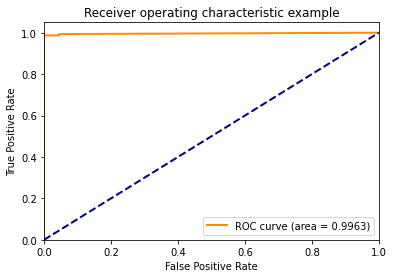

first three predicted probabilities:  [0.0, 0.0, 0.0]
roc_auc_score:  0.9963133640552995
Youden index:  0.235
first three youden predicted results:  [0, 0, 0]
accuracy after apply youden index:  0.9935275080906149
precision:  0.9696969696969697
recall:  0.9675324675324675
top 5 features:  [('atrial_fibrillation_0', 0.0591), ('atrial_fibrillation_1', 0.0577), ('malaise_and_fatigue_0', 0.0573), ('malaise_and_fatigue_1', 0.0562), ('pure_hypercholesterolemia_0', 0.0461)]


In [239]:
roc_auc_analysis(best_rf_model, test_x, test_y)

##Plot Confusion matrix

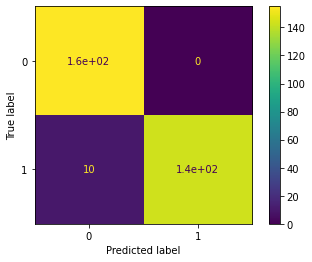

In [240]:
#Plot Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(best_rf_model, test_x, test_y);
plt.grid(False)

###Best estimator features

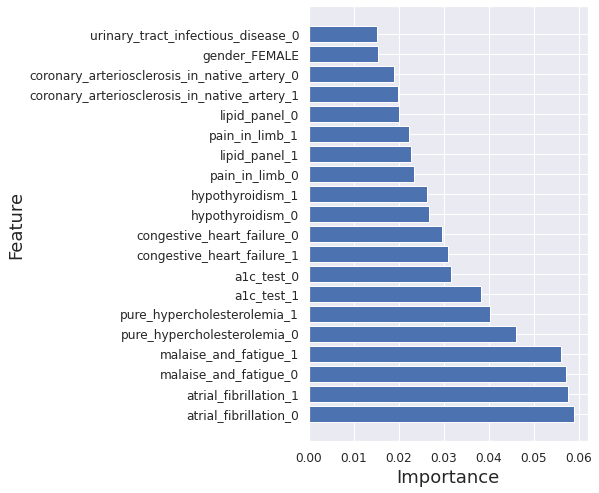

In [242]:
# Extract top 10 contributing features 
f_imp = sorted(zip(best_rf_model.feature_importances_, new_feature_names))[::-1][:20]

# plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'lines.linewidth': 1, 'lines.markersize': 10})
sns.set(style="darkgrid", font_scale=1.1)

plt.figure(figsize=(5, 8))

plt.barh([i[1] for i in f_imp], [i[0] for i in f_imp])
plt.xlabel('Importance', fontsize=18)
plt.ylabel('Feature', fontsize=18)
plt.show()
